#### Author: Tobias Flörchinger, 608227, floercht@hu-berlin.de

# Business Analytics and Data Science - Assignment Submission

## Table of Contents
1. [Introduction](#first-bullet)
2. [Exploratory data analysis ](#second-bullet)
3. [Data preperation](#third-bullet)
<br> 3.1 Feature engineering on known data
<br> 3.2 Feature replication on unknown data
<br> 3.3 Imputation and feature selection
4. [Model tuning and selection](#fourth-bullet)
<br> 4.1 XGBoost
<br> 4.2 RandomForest
<br> 4.3 Stacking Ensemble
5. [Model evaluation and cost-sensitive classification ](#fifth-bullet)
6. [Conclusions](#sixth-bullet)
7. [Literature](#seventh-bullet)

## 1. Introduction  <a class='anchor' id='first-bullet'></a>
In the ongoing digitalization of the world the importance of e-commerce constantly increases. More and more consumers wish to take care of time-consuming shopping of any kind just on the side. Here, online clothing stores in particular face inevitable problems as customers cannot try on the clothes before buying. Hence those shops have to deal with a higher number of returns that are more costly compared to stationary shops. Following the assignment description, the aim is to predict and to cost-sensitively classify future returns of customers such that a clothing online shop can take action in advance to reduce costs.

To do so raw e-commerce data is provided in two datasets. `BADS_WS2021_known.csv` includes the target `return` and in `BADS_WS2021_unknown.csv` the target `return` is to be predicted and classified cost-sensitively. In consecutiv steps the modeling process entails a initial exploratory data analysis, data preperation with feature engineering, selection as well as imputation, model tuning / selection and model evaluation followed, by cost-sensitive classification. 

## 2. Exploratory data analysis  <a class='anchor' id='second-bullet'></a>
First of all the provided raw datasets are investigated in an explanatory way to gain insights in data peculiarities and structures. Summary statistics and graphical representations come in handy here. Incorporating the fact that the data originate from e-commerce, one can improve the understanding for the datasets. This will provide guidance in the subsequent analysis steps and ultimately help to solve the classifictaion problem of interest. 

In [1]:
import os # Importing and writing data
import pandas as pd # General data managment, data wrangling 
import numpy as np # Numerical operations
import seaborn as sns # Plots
import matplotlib.pyplot as plt # Plots
!pip install matplotlib-venn
from matplotlib_venn import venn2 # Plots

The known data `BADS_WS2021_known.csv` and the unknown data `BADS_WS2021_unknown.csv` are loaded from the directory of this notebook.

In [2]:
# Loads .csv datasets from the directory of this file
df_known = pd.read_csv(os.path.join(os.path.dirname(os.path.realpath('608227.ipynb')), 'BADS_WS2021_known.csv'),
                       index_col='order_item_id')
df_unknown = pd.read_csv(os.path.join(os.path.dirname(os.path.realpath('608227.ipynb')), 'BADS_WS2021_unknown.csv'),
                         index_col='order_item_id')

# Can be used to manually provide the directory of the .csv datasets
#df_known = pd.read_csv('.../BADS_WS2021_known.csv', index_col='order_item_id') 
#df_unknown = pd.read_csv('.../BADS_WS2021_unknown.csv', index_col='order_item_id')

In order to get an overview, summaries of both the known data and the unknown data are generated and the first three rows of the former are displayed.

In [3]:
df_known.info()
df_unknown.info()
df_known.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_date     100000 non-null  object 
 1   delivery_date  90682 non-null   object 
 2   item_id        100000 non-null  int64  
 3   item_size      100000 non-null  object 
 4   item_color     100000 non-null  object 
 5   brand_id       100000 non-null  int64  
 6   item_price     100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_title     100000 non-null  object 
 9   user_dob       91275 non-null   object 
 10  user_state     100000 non-null  object 
 11  user_reg_date  100000 non-null  object 
 12  return         100000 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 10.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 100001 to 150000
Data columns (total 12 columns):
 #   Column         Non-Null Count  

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


The known data consists of 100,000 row whereas the unknown data contains 50,000. Apart from the target `return` in the known data, both datasets contain 12 features with common labels. 3 of them are of type `int64` representing IDs i.e. `item_id`, `brand_id` and `user_id` which are of nominal scale. Furthermore 8 of the common features are of type `object` indicating categorial data. Taking a look at the respective feature names as well as the entries reveals that 4 of 8 are time stampes ending with *_date* or *_dob*. The other 4 categorial and nominal scale features specify the *items* and the *users*  more precisely. Only `item_price` is of the type `float64` and of cardinal scale.
Furthermore the non-null count shows missing values in both data sets in the features `delivery_date` and `user_dob`.

To get a better idea of the shaping of each feature and the similarities as well as differences between the known data and unknown data, the unique entries are determined column-wise for both datasets.

In [4]:
print('Unique entries in df_known columns:')
for i in list(df_known.columns):
    print(i)
    print(df_known[i].unique())

Unique entries in df_known columns:
order_date
['2016-06-22' '2016-06-23' '2016-06-25' '2016-06-24' '2016-06-26'
 '2016-06-27' '2016-06-28' '2016-06-29' '2016-06-30' '2016-07-02'
 '2016-07-01' '2016-07-03' '2016-07-04' '2016-07-05' '2016-07-06'
 '2016-07-07' '2016-07-08' '2016-07-09' '2016-07-10' '2016-07-11'
 '2016-07-12' '2016-07-13' '2016-07-14' '2016-07-15' '2016-07-16'
 '2016-07-17' '2016-07-18' '2016-07-19' '2016-07-20' '2016-07-21'
 '2016-07-23' '2016-07-22' '2016-07-24' '2016-07-25' '2016-07-26'
 '2016-07-27' '2016-07-28' '2016-07-30' '2016-07-29' '2016-07-31'
 '2016-08-01' '2016-08-02' '2016-08-03' '2016-08-04' '2016-08-06'
 '2016-08-05' '2016-08-07' '2016-08-08' '2016-08-09' '2016-08-10'
 '2016-08-11' '2016-08-12' '2016-08-13' '2016-08-14' '2016-08-15'
 '2016-08-16' '2016-08-17' '2016-08-18' '2016-08-20' '2016-08-19'
 '2016-08-21' '2016-08-22' '2016-08-23' '2016-08-24' '2016-08-25'
 '2016-08-27' '2016-08-26' '2016-08-28' '2016-08-29' '2016-08-30'
 '2016-08-31' '2016-09-01' '2

In [5]:
print('Unique entries in df_unknown columns:')
for i in list(df_unknown.columns):
    print(i)
    print(df_unknown[i].unique())

Unique entries in df_unknown columns:
order_date
['2016-10-15' '2016-10-16' '2016-10-17' '2016-10-18' '2016-10-19'
 '2016-10-20' '2016-10-22' '2016-10-21' '2016-10-23' '2016-10-24'
 '2016-10-25' '2016-10-26' '2016-10-27' '2016-10-29' '2016-10-28'
 '2016-10-30' '2016-10-31' '2016-11-01' '2016-11-02' '2016-11-03'
 '2016-11-05' '2016-11-04' '2016-11-06' '2016-11-07' '2016-11-08'
 '2016-11-09' '2016-11-10' '2016-11-12' '2016-11-11' '2016-11-13'
 '2016-11-14' '2016-11-15' '2016-11-16' '2016-11-17' '2016-11-19'
 '2016-11-18' '2016-11-20' '2016-11-21' '2016-11-22' '2016-11-23'
 '2016-11-24' '2016-11-26' '2016-11-25' '2016-11-27' '2016-11-28'
 '2016-11-29' '2016-11-30' '2016-12-01' '2016-12-03' '2016-12-02'
 '2016-12-04' '2016-12-05' '2016-12-06' '2016-12-07' '2016-12-08'
 '2016-12-10' '2016-12-09' '2016-12-11' '2016-12-12']
delivery_date
['2017-01-10' '2016-10-16' nan '2016-11-09' '2016-11-05' '2016-10-17'
 '2016-10-26' '2016-11-23' '2016-10-22' '2016-10-25' '2016-11-16'
 '2016-10-19' '2016-1

The values of `order_date` in the known data come from a time span from `2016-06-22` to `2016-09-11` whearas the unknown data originate from `2016-10-15` to `2016-12-12`. Considering the e-commerce background the deviation in the time spans implies data from different seasons what possibly results in unequal distributions of the features between the two data sets.

Moreover eye-balling unique entries of the remaining features the missing values `nan` become visible along with the conspicuous `delivery_date` entry `1994-12-31`. This anomalous entries $M$ are examined by checking for independence from the outcome `return` i.e. $y$. Hence the corresponding return rates are calculated. Independence $M \perp y$ holds if the distribution of `return` for $M$ recovers the overall return rate i.e. $p(y=1)=p(y=1|M)$.

In [6]:
# Overall return rate
print('The overall return rate in the known dataset is %0.4f.' % df_known['return'].mean())
print('')
# Return rate delivery_date = 1994-12-31
Int = df_known[df_known['delivery_date'] == '1994-12-31']
print('Return rate for delivery_date = 1994-12-31: {:.4f}'.format(sum(Int['return'])/(len(Int['return'])+1))) 
# Return rate delivery_date = nan
Int = df_known[df_known['delivery_date'].isna()]
print('Return rate for delivery_date = nan: {:.4f}'.format(sum(Int['return'])/(len(Int['return'])+1)))
# Return rate user_dob = nan
Int = df_known[df_known['user_dob'].isna()]
print('Return rate for user_dob = nan: {:.4f}'.format(sum(Int['return'])/(len(Int['return'])+1)))

The overall return rate in the known dataset is 0.4582.

Return rate for delivery_date = 1994-12-31: 0.3756
Return rate for delivery_date = nan: 0.0000
Return rate for user_dob = nan: 0.4547


Missing values in `user_dob` are independent of `return`. However, this is not the case for the other anomalous entries. Especially the missing values in `delivery_date` are not independend of `return`. Here the return rate is 0 hence missing values `nan` in `delivery_date` are missing not at random.

Let's focus on possible differences in feature realisations due to the deviations in time spans between the datasets. Having a high share of ordinal scale features, again unique entries in both datasets are identified and compared. 

         order_date  delivery_date  item_id  item_size  item_color  brand_id  \
known            82            124     1943        102          77       135   
unknown          59             89     1407        103          67       120   

         item_price  user_id  user_title  user_dob  user_state  user_reg_date  
known           252    19205           5      9248          16            573  
unknown         214    12854           5      7218          16            660  


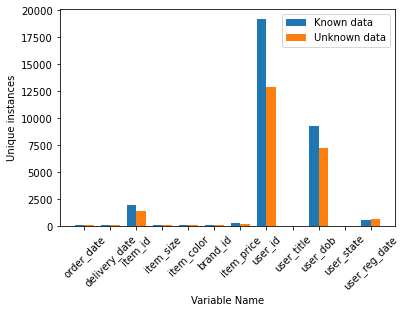

In [7]:
# Setup dataframe for comparing quantity of unique entires in both datasets
data_unique = pd.DataFrame(0, index =['known', 'unknown'], columns = df_unknown.columns)

for i in list(df_known.columns[0:12]):
    data_unique[i][0] = len(df_known[i].unique()) # Add quantity of unique entires in known data
for i in list(df_unknown.columns): 
    data_unique[i][1] = len(df_unknown[i].unique()) # Add quantity of unique entires in unknown data 
print(data_unique)

known = pd.Series(data_unique.iloc[0], df_unknown.columns) # Quantity of unique entires in known data to series
unknown =  pd.Series(data_unique.iloc[1], df_unknown.columns) # Quantity of unique entires in unknown data to series

# Generate bar plot
ind = np.arange(len(unknown)) # Evenly spaced values
width = 0.35 # Bar width

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, known, width,
                label='Known data') # Bar 1
rects3 = ax.bar(ind + width/2, unknown, width,
                label='Unknown data') # Bar 2
ax.set_ylabel('Unique instances')
ax.set_xlabel('Variable Name')
ax.set_xticks(ind)
ax.set_xticklabels(df_unknown.columns, rotation=45)
ax.legend();

The number of unique entries in the known data overtop the unknown data mostly. Adding on to this the overlaps are of interest. For `user_title` and `user_state` the number of entries are equal and eye-balling the earlier printed unique entries shows no difference in realisations. Time stamps are of minor interest since they yield hardly any useable information without further procession. Therefore overlaps for `user_id`, `item_price`, `item_color`, `item_size`, `item_id` and `brand_id` are generated and displayed with venn diagramms.

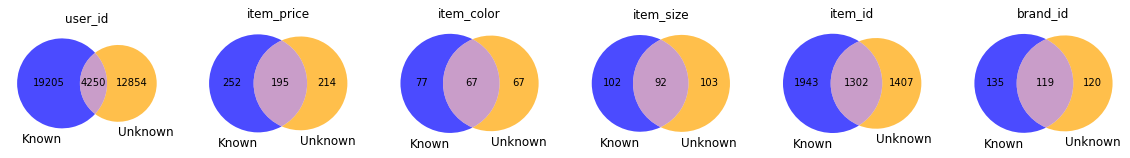

In [8]:
L_venn = ['user_id', 'item_price', 'item_color', 'item_size', 'item_id', 'brand_id']

fig, axs = plt.subplots(ncols=6,figsize=(20, 5)) # Generate subplots to be filled by ven diagramms
for i in range(0, len(L_venn)):
    # Generate overlap by leftjoining on index = unique L_venn[i] and counting non nan values in the joined column
    overlap = pd.merge(df_known[L_venn[i]].value_counts(), df_unknown[L_venn[i]].value_counts(), how='left', 
                       left_index=True, right_index=True).count(axis=0)[1] 
    # Generate venn diagramms with unique entries and overlap
    v1 = venn2(subsets = (len(df_known[L_venn[i]].unique()), len(df_unknown[L_venn[i]].unique()), overlap), 
               set_labels = ('Known', 'Unknown'), set_colors=('blue', 'orange'), alpha = 0.7, ax=axs[i])
    # Fill subplots
    axs[i].set_title(L_venn[i])
plt.show()

Nearly every entry of `item_color` and `brand_id` in the unknown data has a equivalence in the known data. For `item_price`, `item_color` and `item_id` this is not the case since each have around 10% unique entries in the unknown data without equivalence in the known data. The difference in the datasets is especially large for `user_id` roughly 66% of unique entries in the unknown data have no equivalence in the known data. This imbalance causes problems and has to be bear in mind during the upcoming sections.

Since `item_price` is of cardinal scale the feature distribution in both datasets and the interaction with `return` in the known dataset are investigated.

Only 4 items have a price higher than 500 in the known data.


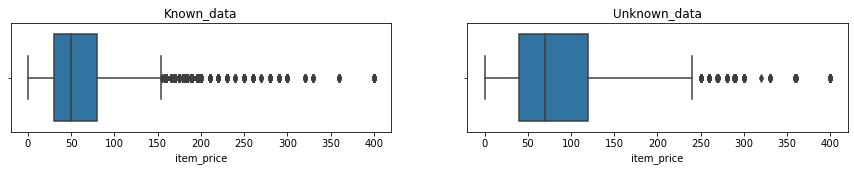

In [9]:
# Generate subplots
fig, axs = plt.subplots(ncols=2,figsize=(15, 2))
# Fill subplots with boxplot for known and unknown data (Only prices lower than 500) 
sns.boxplot(x=df_known['item_price'].where(df_known['item_price'] < 500),ax=axs[0]).set_title('Known_data') 
sns.boxplot(x=df_unknown['item_price'],ax=axs[1]).set_title('Unknown_data')
print('Only %0.f items have a price higher than 500 in the known data.' % 
      df_known['item_price'].where(df_known['item_price'] > 500).count())

The value range of the empirical distribution for both datasets is the same. However, the boxplots show that the mean of `item_price` in the known data lies around 50 whereas the mean in the unknown data is remarkably higher. This holds true comparing the 25% and 75% quantiles in the boxplots. Considering the deviating time spans of `order_date` reveals that the unknown data comes from the autumn/winter season and the known data from spring/summer. Hence the shifted differences in realisations of `item_price` between datasets correspond to the price of cloths in the respective seasons plus offcycle purchases. Following this reasoning and the sufficient overlap there is no necessity to handle outliers.

The return rate rises in the quantiles up to mean(return) = 0.4582 of the known dataset.


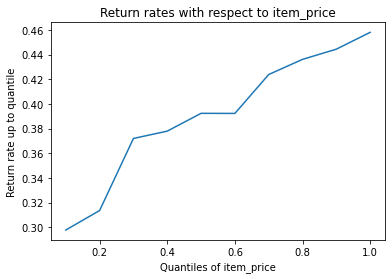

In [10]:
L_ret = list()
probv = np.arange(0.1, 1.1, 0.1) # Probability values 
quant = np.quantile(df_known['item_price'], probv) # 'item_price' quantiles 
for i in quant:
    Int = df_known[df_known['item_price'] <= i]
    L_ret.append(sum(Int['return'])/(len(Int['return'])+1)) # Return rate up to a quantile
plt.plot(probv,L_ret) # Plot quantile return rates
plt.title('Return rates with respect to item_price')
plt.xlabel('Quantiles of item_price')
plt.ylabel('Return rate up to quantile')
print('The return rate rises in the quantiles up to mean(return) = %0.4f of the known dataset.' % df_known['return'].mean())

Plotting the `item_price` quantiles against the return rate in the respective quantile demonstrates that the likelihood for a positiv `return` $y_{i} = 1$ increases with a higher `item_price`.

## 3. Data preperation   <a class='anchor' id='third-bullet'></a>

Using the insights of the explanatory data analysis, this section aims on transforming the raw datasets with data manipulation, processing and cleaning in order to derive high quality features in appropriate form. Therefore feature engineering is conducted separately on both the known data and unknown data to avoid data leaks and imputation of occurring missing values as well as feature selection is conducted.

### Feature engineering on known data
For feature engineering four approaches are considered. Time stamps are used to generate peridos of interest, simple operands (counts and sums) yield aggregated information of feature groups, the weight of evidence (WoE) encoding is considered to transforms categorial as well as discrete features and flaggs that mark similar dataset rows.


At first meaningful periods between the time stamps are derived. These are `delivery_duration`, `user_age` and `registration_time`. E.g. intuitively a higher `delivery_duration` corresponds to a higher return rate.

In [11]:
# Duration of delivery between order to arrival
df_known['delivery_duration'] = (pd.to_datetime(df_known['delivery_date']) - pd.to_datetime(df_known['order_date'])).dt.days
df_known.loc[df_known.delivery_duration < 1, 'delivery_duration'] = df_known['delivery_duration'].median() # Replace neg. values with median
df_known.loc[df_known.delivery_duration.isna(), 'delivery_duration'] = 0 # Impute nan with 0
# Age of user at order 
df_known['user_age'] = round((pd.to_datetime(df_known['order_date']) - pd.to_datetime(df_known['user_dob'])).dt.days/365.25)
df_known.loc[df_known.user_age.isna(), 'user_age'] = df_known['user_age'].median() # Replace nan with median
# Days between registration and order
df_known['registration_time'] = abs((pd.to_datetime(df_known['order_date']) - pd.to_datetime(df_known['user_reg_date'])).dt.days)

`delivery_duration` is based on `delivery_date` which has `nan` and `1994-12-31` entries. To account for the latter, negative values of `delivery_duration` are substituted with the median. Since `nan` entries have a return rate of 0, the `delivery_duration` of those is set to 0 indicating that the items were never in delivery. This could be due to some internal unobserved mechanism e.g. cancelation before dispatch without any costs arising.
Likewise `user_age` is based on `nan` entries in `user_dob`. Here the median of `user_age` is used for imputation.

In [12]:
# Plot unique entries of 'delivery_duration' and 'user_age'
print('delivery_durations:')
print(df_known['delivery_duration'].unique())
print('user_ages:')
print(df_known['user_age'].unique())

delivery_durations:
[  5.   0.  13.   3.   9.  25.   4.   6.  11.  26.  33.  10.  12.   1.
  24.   2.   8.  38.   7.  35.  47.  67.  29.  30.  36.  59.  27.  39.
  23.  28.  31.  32.  22.  34.  57.  55.  48.  41.  21.  40.  37.  43.
  70.  44.  42.  68.  20.  65.  19.  82.  18.  51.  50.  69.  54.  53.
  46.  62.  60.  52.  17.  49.  66.  56.  15.  45.  16.  14.  58.  64.
  63.  61.  88.  89.  96. 101.  84.  98.  80.  74.  83.  95.  76.  97.
  94. 102.  87. 153. 106.  72.  99.  92.  93.  71.  78.  75.  90.  86.
  91. 112. 116.  81. 173. 139. 105.  73.  85. 114. 110.  77. 126. 113.
 104. 125. 111.  79. 135. 118. 122. 109. 108. 103. 107. 140.]
user_ages:
[ 47.  46.  52.  54.  56.  50.  60.  59.  55.  48.  51.  53.  65.  67.
  57.  58.  37.  49.  42.  74.  66.  45.  43.  61.  63.  79.  64.  68.
  69.  75. 116.  62.  73.  34.  44.  71.  35.  38.  41.  70.  40.  39.
  27.  72.  91.  33.  31.  28.  30.  36.  26.  32.  11.  77.  23.  82.
  25.  24. 105.  29.  83. 115.   5.  80. 110.   6.  20.

The unique entries of `delivery_duration` and `user_age` show unplausible values. The `user_age` exceeds 100 years and `delivery_duration` of over three months seems inflated. Thus truncation based on Tukey's rule of thumb is used to handle outliers.

In [13]:
pd.options.mode.chained_assignment = None # Disable warnings for chained assignments

# Apply truncation to 'delivery_duration' and 'user_age'
x_new = df_known['delivery_duration'].copy()
IQR = x_new.quantile(0.75) - x_new.quantile(0.25) # Calculate IQR
upper_dur = x_new.quantile(0.75) + 1.5*IQR # Define upper/lower bound
lower_dur = x_new.quantile(0.25) - 1.5*IQR
df_known['delivery_duration'][x_new < lower_dur] = lower_dur # Truncation
df_known['delivery_duration'][x_new > upper_dur] = upper_dur

x_new = df_known['user_age'].copy()
IQR = x_new.quantile(0.75) - x_new.quantile(0.25) # Calculate IQR
upper_age = x_new.quantile(0.75) + 1.5*IQR # Define upper/lower bound
lower_age = x_new.quantile(0.25) - 1.5*IQR
df_known['user_age'][x_new < lower_age] = lower_age # Truncation
df_known['user_age'][x_new > upper_age] = upper_age

# Again plot unique entries of 'delivery_duration' and 'user_age'
print('delivery_durations:')
print(df_known['delivery_duration'].unique())
print('user_ages:')
print(df_known['user_age'].unique())

delivery_durations:
[5.  0.  8.5 3.  4.  6.  1.  2.  8.  7. ]
user_ages:
[47. 46. 52. 54. 56. 50. 60. 59. 55. 48. 51. 53. 65. 67. 57. 58. 37. 49.
 42. 72. 66. 45. 43. 61. 63. 64. 68. 69. 62. 34. 44. 71. 35. 38. 41. 70.
 40. 39. 32. 33. 36.]


The range of values for `delivery_duration` and `user_age` shrinks drasticly by the truncation confirming that the outlying values where of low fequency.

In the next step simple operands i.e. counts and sums are used on the raw features. Thereby different levels of granularity are addressed considering subgroups created by interactions between the raw features. On lower granularity `item_id` alone can indicate popular items. Similarities in the order level defined by groups of `order_date` and `user_id` are especially interesting. The focus here is on combinations with raw features directly connected to the e-commerce products i.e. `item_id`, `brand_id`, `item_price`, `item_color` and `item_size`.
<br>
Following this, let's generate respective count features that resemble the frequency of occuring entry combinations defined by  subgroups of raw features.

In [14]:
def addcounts(groupby, new_column, data):
    Int = pd.DataFrame(data.groupby(groupby)['item_color'].count()) # Groups data by raw features and generates counts of group row.
    Int.columns = [new_column] # Rename the new column
    Int.reset_index(inplace=True) # Reindex
    return(pd.merge(data, Int, how='left', on=groupby)) # Merge new column to dataset based on the groupby features

In [15]:
# A list of lists. In the latter the first entry will be grouped by (occasionally a list again) and the second is the new column name.
           # One feature to group by
L_count = [[['user_id'], 'total_items_user',], [['item_id'],'item_count'], [['brand_id'], 'brand_count'],
           [['user_age'],'age_count'], [['item_price'],'price_count'], [['item_color'], 'color_count'], [['item_size'],'size_count'],
           # Two features to group by
           [['user_id','item_color'],'color_per_user'], [['user_id','order_date'],'items_per_order'],
           # Three features to group by (only order level)
           [['order_date','user_id','brand_id'],'user_brand_count'],[['order_date','user_id','item_color'],'user_color_count'], 
           [['order_date','user_id','item_id'],'user_item_count'], [['order_date','user_id','item_price'],'user_price_count']]

for i in range(0,len(L_count)): # Loop over L_tocountby_newcol
    df_known = addcounts(L_count[i][0], L_count[i][1], df_known) # Call groupby and new column name for addcounts

print(' The %0.0f new features where generated.' % len(L_count))
df_known.head(3)

 The 13 new features where generated.


,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,...,age_count,price_count,color_count,size_count,color_per_user,items_per_order,user_brand_count,user_color_count,user_item_count,user_price_count
0,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,...,3855,9085,314,5611,2,2,2,1,1,1
1,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,...,3855,66,8708,97,1,2,2,1,1,1
2,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,...,3637,4699,8708,8966,15,9,2,7,1,2


The majority of count features are defined based on one raw feature. The grouping for higher granularity is done with up to three raw features and mostly targets the order level. At this point 29 features exist in the dataset.

Now the corresponding sum of the sole cardinal scaled feature `item_price` is considered instead of the group frequencies. Knowing from the exploratory data analysis that `item_price` has explanatory power regarding the target `return`, the incorporation captures new information deviating from the counts. This eventually yields even more informative features.
<br>
With the reasoning from the e-commerce background single raw features, the order level and product connected two feature combinations with `brand_id`, `user_id` and `item_id` are grouped.

In [16]:
def addsums(groupby, new_column, data):
    Int = pd.DataFrame(data.groupby(groupby)['item_price'].sum()) # Groups by raw features and sums 'item_price' of group row.
    Int.columns = [new_column] # Rename the new column
    Int.reset_index(inplace=True)  # Reindex
    return(pd.merge(data, Int, how='left', on=groupby))  # Merge new column to dataset based on the groupby features

In [17]:
# A list of lists. In the latter the first entry will be grouped by (occasionally a list again) and the second is the new column name.   
         # One feature to group by (for lack of reasoning size_sales and color_sales are neglected)
L_sum = [[['user_id'], 'user_sales'], [['item_id'], 'item_sales'], [['brand_id'], 'brand_sales'], [['order_date'], 'sales_per_day'],
         # Two and three feature to group by on order level
         [['order_date','user_id'],'value_order'],[['order_date','user_id', 'item_color'], 'sales_user_color'],[['order_date','user_id', 'brand_id'], 'sales_user_brand'], 
         [['order_date','user_id', 'item_id'], 'sales_user_item'], [['order_date','user_id', 'item_size'], 'sales_user_size'],
         # Every possible combination of brand_id, user_id, item_id with eachother and item_color, item_size using two features to group
         [['brand_id','item_color'],'brand_color_sales'], [['brand_id','item_id'],'brand_item_sales'], [['brand_id','item_size'],'brand_size_sales'], [['brand_id','user_id'],'brand_user_sales'],
         [['user_id','item_color'],'user_color_sales'], [['user_id','item_id'],'user_item_sales'], [['user_id','item_size'],'user_size_sales'],
         [['item_id','item_color'],'item_color_sales'], [['item_id','item_size'],'item_size_sales']]

for i in range(0,len(L_sum)): # Loop over L_tosumby_newcol
    df_known = addsums(L_sum[i][0], L_sum[i][1], df_known) # Call groupby and new column name for addsums

print(' %0.0f new features where generated.' % len(L_sum))
df_known.head(3)

 18 new features where generated.


,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,...,sales_user_size,brand_color_sales,brand_item_sales,brand_size_sales,brand_user_sales,user_color_sales,user_item_sales,user_size_sales,item_color_sales,item_size_sales
0,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,...,49.90,5863.83,1088.15,6860.2,86.25,66.30,49.90,49.90,419.40,309.35
1,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,...,19.95,3344.33,555.00,1655.1,86.25,19.95,19.95,19.95,99.15,99.30
2,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,...,328.30,29736.60,3901.90,29574.9,179.80,649.50,79.90,543.50,1278.40,1397.40


After adding sums of `item_price` by groups the dataset contains 47 features.

The Weight of Evidence (WoE) encoding is applied to relevant ordinal scaled raw features, the count features and discretized sum features. For the sum features a variant of the [equal-width discretizer](https://towardsdatascience.com/an-introduction-to-discretization-in-data-science-55ef8c9775a2) is used for binning. Since return rates are monotonically increasing in `item_price` it seems natural to round the continous values of the sum features instead of expensively tuning the width $w = \frac{(\text{value}_{max}~ - ~\text{value}_{min})}{N}$. This is also straightforward applicable to the unknown data.
<br>
Heuristically `item_price` is rounded on tens because of the clear value range. However, a rounding function is defined for different digits, because the range for binning is opaque for the sum features. Hence values are rounded on tens, hundreds and thousands indicated by the feature name endings `_R1`, `_R2` and `_R3`.

In [18]:
def addround(col,data,dig):
    Int = pd.DataFrame(round(data[col],-dig)) # Round sum column 
    Int.columns = [col + '_R' + str(dig)] # Rename interim data
    return(pd.merge(data, Int, how='left', left_index=True, right_index=True)) # Merge interim data to known data

In [19]:
L_sums = list(df_known.columns[29:47]) # Define the sum columns in the known data 
for j in range(1,4):
    for i in L_sums:
        df_known = addround(i,df_known,j) # Merge rounded sum columns
L_round1 = list(df_known.columns[47:65]) # List of sum feature columns rounded on tens
L_round2 = list(df_known.columns[65:83]) # List of sum feature columns rounded on hundreds
L_round3 = list(df_known.columns[83:101]) # List of sum feature columns rounded on thousands
df_known['item_price_R'] = round(df_known['item_price'],-1) # Generate rounded 'item_price' column

The rounded sum features are appended to the known data. So 54 discretized features from column 47 to 101 were generated. To compare them and at the same time evaluate all other features the adjusted WoE encoding is applied and the Information Values (IVs) are calculated. The higher the IV the more information is contained in a feature what makes the WoE encoding expedient. Hence the focus is on IVs first to identify adequate features for the adjusted WoE encoding. The IV lower bound threshold is set to 0.05. Let's define 

$$P(\text{Good})_j = P(Z=z_j|y=0) = E\big(\mathbb{1}_{\{Z=z_j|y=0\}}\big) = \frac{1+\sum_{i=1}^n\mathbb{1}_{\{Z=z_j|y_{i}=0\}}}{2+\sum_{i=1}^n\mathbb{1}_{\{y_{i}=0\}}}$$

with $y=0$ as the good class of `return`, Z as feature of interest and the adjustment factors, 1 in the numerator and 2 in the denominator. Subsequently the adjusted WoE and IV are given by

$$ \text{WoE}_j = ln\bigg(\frac{P(\text{Good})_j}{P(\text{Bad})_j}\bigg) ~~~~~ \text{and} ~~~~~ \text{IV} = \sum_j  \big( \big( P(\text{Good})_j - P(\text{Bad})_j \big) \times \text{WoE}_j \big)$$


In [20]:
L_woe = list() # List of features for WoE encoding
L_iv_val = list() # List of features IV values
L_iv_col = list() # List of features column names
for i in list(df_known.columns):
    df_woe = (pd.crosstab(df_known[i], df_known['return']) # Loop through columns to create crosstabs
                .assign(woe=lambda dfx: np.log(((dfx[0]+1)/(df_known['return'][df_known['return']==0].count()+2)) # Append WoE encoding (adjustment added to avoid Inf)
                                               / ((dfx[1]+1)/(df_known['return'][df_known['return']==1].count()+2))))  
                .assign(iv=lambda dfx: np.sum(dfx['woe']*(((dfx[0]+1)/(df_known['return'][df_known['return']==0].count()+2))
                                                          - ((dfx[1]+1)/(df_known['return'][df_known['return']==1].count()+2)))))) # Append IV value
    print(df_woe.head(2)) # Show frist 2 rows of crosstab
    print()
    L_iv_val.append(df_woe['iv'].mean()) # Write IV value to list
    L_iv_col.append(i) # Write respective column to list
    if df_woe['iv'].mean() > 0.05: 
        L_woe.append(df_woe.index.name) # Features with IV values greater than 0.03 are considered for WoE encoding via L_woe list

return        0    1       woe        iv
order_date                              
2016-06-22   33   64 -0.815692  0.042094
2016-06-23  692  615 -0.049882  0.042094

return           0    1       woe        iv
delivery_date                              
1994-12-31     669  403  0.338198  0.049374
2016-06-26     732  802 -0.258874  0.049374

return    0   1       woe        iv
item_id                            
1        86  78 -0.071205  0.435115
2        89  58  0.254607  0.435115

return       0    1       woe        iv
item_size                              
1           22   18  0.023390  0.056068
10         128  149 -0.318488  0.056068

return       0  1       woe        iv
item_color                           
?           56  5  2.083627  0.034166
almond      12  2  1.298672  0.034166

return       0     1       woe        iv
brand_id                                
1         4279  4102 -0.125430  0.155424
2          484   350  0.155698  0.155424

return        0   1       woe     

return           0  1       woe        iv
brand_sales_R1                           
0.0             46  2  2.583870  0.154434
40.0             4  1  0.748626  0.154434

return              0    1       woe        iv
sales_per_day_R1                              
3750.0             33   64 -0.815692  0.042094
14540.0           188  100  0.458962  0.042094

return            0   1       woe        iv
value_order_R1                             
0.0             134  17  1.847238  0.199554
10.0            114  20  1.532745  0.199554

return                  0    1       woe        iv
sales_user_color_R1                               
0.0                   421   58  1.799803  0.156489
10.0                 2356  714  1.025197  0.156489

return                  0    1       woe        iv
sales_user_brand_R1                               
0.0                   398   52  1.851005  0.162245
10.0                 1650  469  1.088739  0.162245

return                 0    1       woe        iv
sales

return                  0      1       woe        iv
user_item_sales_R3                                  
0.0                 53709  45308  0.002429  0.001158
1000.0                472    495 -0.215146  0.001158

return                  0      1       woe        iv
user_size_sales_R3                                  
0.0                 48356  39202  0.042193  0.012609
1000.0               5284   6067 -0.305821  0.012609

return                   0      1       woe        iv
item_color_sales_R3                                  
0.0                   8830   4144  0.588700  0.097611
1000.0               16024  11254  0.185673  0.097611

return                  0      1       woe        iv
item_size_sales_R3                                  
0.0                 11494   7773  0.223462  0.019611
1000.0              18913  15556  0.027727  0.019611

return           0     1       woe        iv
item_price_R                                
0.0            575    83  1.757626  0.132347
10.0     

Eye-balling the IV results for the raw features shows that the time stamps `user_dob` and `user_reg_date` as well as `registration_time` are included in the WoE list `L_woe`. Due to the deviating time span between known and unknown data it is likely that the WoEs of those time features do not generalize well. 

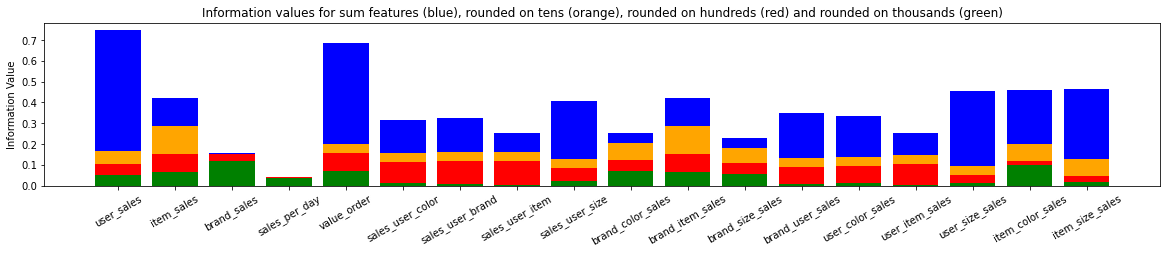

In [21]:
plt.figure(figsize=(20,3))
plt.bar(range(len(L_iv_col[29:47])), L_iv_val[29:47], color = "blue") # IVs of on thousands rounded sum features
plt.bar(range(len(L_iv_col[47:65])), L_iv_val[47:65], color = "orange") # IVs of on tens rounded sum features
plt.bar(range(len(L_iv_col[65:83])), L_iv_val[65:83], color = "red") # IVs of on hundreds rounded sum features 
plt.bar(range(len(L_iv_col[83:101])), L_iv_val[83:101], color = "green") # IVs of on thousands rounded sum features
plt.xticks(range(len(L_iv_col[29:47])), L_iv_col[29:47], rotation=30)
plt.ylabel('Information Value')
plt.title('Information values for sum features (blue), rounded on tens (orange), rounded on hundreds (red) and rounded on thousands (green)')
plt.show() # Barplot the IVs of sum features against the rounded features

In comparison sum features rounded on thousands yield the lowest IV (green) and no rounding yields the highest (blue). However, the extemely small bins with seemingly clear distinction between good and bad do not generalize well. Further we know from the exploratory data analysis that there is no perfect overlap in `item_price` throughout the datasets and the distributions of `item_price` in the unknown dataset is shifted. Hence sums of `item_price` by groups in the unknown dataset likely have different and higher values. Thus rounding can help to yield more general WoEs. Because of the good improvement over rounding on thousands (green) and mostly smaller drawback compared to rounding on tens (yellow), sum features are rounded on hundreds (red). With this the WoE encoding list `L_woe` is adjusted.

In [22]:
L_remove = ['user_dob', 'user_reg_date', 'registration_time', # Time periods change across the two datasets
            'item_price', # For WoE replaced by item_price_R
            'return'] + L_sums + L_round1 + L_round3 #  Combine all remove lists (L_sums replaced by respective roundings)
L_woe = [var for var in L_woe if var not in L_remove] # Remove from L_woe
print(L_woe)

['item_id', 'item_size', 'brand_id', 'user_id', 'delivery_duration', 'total_items_user', 'item_count', 'brand_count', 'price_count', 'size_count', 'items_per_order', 'user_sales_R2', 'item_sales_R2', 'brand_sales_R2', 'value_order_R2', 'sales_user_color_R2', 'sales_user_brand_R2', 'sales_user_item_R2', 'sales_user_size_R2', 'brand_color_sales_R2', 'brand_item_sales_R2', 'brand_size_sales_R2', 'brand_user_sales_R2', 'user_color_sales_R2', 'user_item_sales_R2', 'user_size_sales_R2', 'item_color_sales_R2', 'item_price_R']


For the WoE encoding unnecessary and suspecious features were removed from `L_woe`. The required features appear in `L_woe`, hence WoEs are generated and merged to the known data.

In [23]:
for i in L_woe:
    df_woe = (pd.crosstab(df_known[i] ,df_known['return']) # Loop through columns to create crosstabs
                .assign(woe=lambda dfx: np.log(((dfx[0]+1)/(df_known['return'][df_known['return']==0].count()+2)) # Append WoE encoding (adjustment added to avoid Inf)
                                               / ((dfx[1]+1)/(df_known['return'][df_known['return']==1].count()+2)))))
    Int = pd.DataFrame(df_woe['woe']) # WoE values to interim dataset
    Int.reset_index(inplace=True) # WoE values to interim dataset
    Int = Int.rename(columns={'woe':'woe_'+i}) # Reindex
    df_known = pd.merge(df_known, Int, how='left', on=[i]) # Merge interim dataset to known dataset

Finally, rows of the known data that have relevant features in common are flagged. This is done especially on the order level to identify similar types of products of which a customer possibly just retains few and returns the rest.
<br> Considering the return rate of 0 for missings in `delivery_date` a flag `flag_not_delivered` is derived.

In [24]:
df_known['flag_not_delivered'] = (df_known['delivery_date'].isna()).astype(int) # Flag for `delivery_date` = nan

The information of `flag_not_delivered` is used to adjust all other flags. Those are generated on duplicates of relevant feature subsets. 

In [25]:
def addflag(dat, name, subs):
        dat[name] = (dat.duplicated(subset=subs, keep=False)).astype(int) - dat['flag_not_delivered'] # Flag duplicates of subset 
        dat.loc[dat[name] < 0, name] = 0 

In [26]:
print(' There are %0.0f duplicates in the known data.' % df_known.duplicated(subset=df_known.columns, keep='first').sum())

 There are 1002 duplicates in the known data.


There are only view duplicates in the known dataset with no evidence for data problems. They equally could indicate customers that ordered the same item multiple times. The latter is assumed since every row has its own index `order_item_id`.

In [27]:
addflag(df_known, 'flag_double_order', df_known.columns) # Same item
addflag(df_known, 'flag_same_color', ['item_color','order_date', 'user_id']) # Same color in order
addflag(df_known, 'flag_same_item_color', ['item_id','item_color','order_date', 'user_id']) # Same item and color in order
addflag(df_known, 'flag_same_price_color', ['item_price','item_color','order_date', 'user_id']) # Same price and color in order
addflag(df_known, 'flag_same_brand_color', ['brand_id','item_color','order_date', 'user_id']) # Same brand and color in order

The duplicates are flagged as `flag_double_order`. The order level is addressed around the feature `item_color` as main characteristic of equivalence between two items. This is extended by additional incorporating `item_id`,`item_price` and `brand_id`.

### Feature replication on unknown data 

Let's turn to the unknown dataset. Here the aim is to replicate the relevant features of the known dataset without leaking any unrealized information. It is assumable that the information in the unknown dataset occur aggregated on the order level. This means as a customer is placing an order his whole basket is revealed to the online shop. Within this level calculations can be made without access to unrealized information from across the unknown dataset.

The replication of the features is conducted in the same order as for the known data.

In [28]:
# Duration of delivery
df_unknown['delivery_duration'] = (pd.to_datetime(df_unknown['delivery_date']) - pd.to_datetime(df_unknown['order_date'])).dt.days
df_unknown.loc[df_unknown.delivery_duration < 1, 'delivery_duration'] = df_known['delivery_duration'].median() # Replace neg. values with median
df_unknown.loc[df_unknown.delivery_duration.isna(), 'delivery_duration'] = 0 # Impute nan with 0
# Age of user
df_unknown['user_age'] = round((pd.to_datetime(df_unknown['order_date']) - pd.to_datetime(df_unknown['user_dob'])).dt.days/365.25)
df_unknown.loc[df_unknown.user_age.isna(), 'user_age'] = df_known['user_age'].median() # Impute nan with median
# Days between registration and order
df_unknown['registration_time'] = abs((pd.to_datetime(df_unknown['order_date']) - pd.to_datetime(df_unknown['user_reg_date'])).dt.days)

In [29]:
# Truncation of 'delivery_duration'
df_unknown['delivery_duration'][df_unknown['delivery_duration'] < lower_dur] = lower_dur
df_unknown['delivery_duration'][df_unknown['delivery_duration'] > upper_dur] = upper_dur
# Truncation of 'user_age'
df_unknown['user_age'][df_unknown['user_age'] < lower_age] = lower_age
df_unknown['user_age'][df_unknown['user_age'] > upper_age] = upper_age

`delivery_duration`, `user_age` and `registration_time` are derived like for the known dataset since this can be done for each row separately. However, the median values of the known dataset are used for imputation and the truncation is done by taking recourse on the lower and upper truncation bounds calculated for the known dataset in order to avoid data leaks.

In [30]:
# List of lists of count features to be merged from the known data since a definition on the unknown data would leak data information
L_merge = [['user_id', 'total_items_user'], ['item_id','item_count'], ['brand_id', 'brand_count'], ['user_age','age_count'], 
           ['item_price','price_count'], ['item_color', 'color_count'], ['item_size', 'size_count']]
# Merge from known data by loop over the lists in L_merge. The first entry is the key and the second the merged column of interest.
for i in range(0,len(L_merge)):
    df_unknown = pd.merge(df_unknown, df_known[[L_merge[i][0], L_merge[i][1]]].drop_duplicates(), how='left', on=L_merge[i][0])
df_unknown = pd.merge(df_unknown, df_known[['user_id','item_color','color_per_user']].drop_duplicates(), 
                      how='left', on=('user_id','item_color'))

In [31]:
# List of lists of features to be generated on the unknown data i.e. on the order level. Here information become available at a time.
L_count = [[['user_id','order_date'],'items_per_order'],[['order_date','user_id','brand_id'],'user_brand_count'],
           [['order_date','user_id','item_color'],'user_color_count'], [['order_date','user_id','item_id'],'user_item_count'], 
           [['order_date','user_id','item_price'],'user_price_count']]
# Use of the addcounts function as for the known data
for i in range(0,len(L_count)):
    df_unknown = addcounts(L_count[i][0], L_count[i][1], df_unknown)

Count features that rely on the availability of the whole dataset are merged from the known data. Since the order level becomes available contemporaneously, count features that emerge there are generated with `addcounts()` as before.

In [32]:
# List of lists of sum features to be merged from the known data since a definition on the unknown data would leak data information
L_merge = [['user_id', 'user_sales'], ['item_id', 'item_sales'], ['brand_id', 'brand_sales']]
# Merge from known data by loop over the lists in L_merge. The first entry is the key and the second the merged column of interest.
for i in range(0,len(L_merge)):
    df_unknown = pd.merge(df_unknown, df_known[[L_merge[i][0], L_merge[i][1]]].drop_duplicates(), how='left', on=L_merge[i][0])

In [33]:
# List of lists of features to be generated on the unknown data i.e. on the order level. Here information become available at a time.
L_sum = [[['order_date'], 'sales_per_day'], [['order_date','user_id'],'value_order'], 
         [['order_date','user_id', 'item_color'], 'sales_user_color'],[['order_date','user_id', 'brand_id'], 'sales_user_brand'], 
         [['order_date','user_id', 'item_id'], 'sales_user_item'], [['order_date','user_id', 'item_size'], 'sales_user_size']]
# Use of the addsumss function as for the known data
for i in range(0,len(L_sum)):
    df_unknown = addsums(L_sum[i][0], L_sum[i][1], df_unknown)

In [34]:
# List of lists of sum features to be merged from the known data since a definition on the unknown data would leak data information
L_merge = [['brand_id','item_color','brand_color_sales'], ['brand_id','item_id','brand_item_sales'], ['brand_id','item_size','brand_size_sales'], ['brand_id','user_id','brand_user_sales'],
           ['user_id','item_color','user_color_sales'], ['user_id','item_id','user_item_sales'], ['user_id','item_size','user_size_sales'],
           ['item_id','item_color','item_color_sales'], ['item_id','item_size','item_size_sales']]
# Merge from known data by loop over the lists in L_merge. The first two entry are keys and the third the merged column of interest.
for i in range(0,len(L_merge)):
    df_unknown = pd.merge(df_unknown, df_known[[L_merge[i][0], L_merge[i][1], L_merge[i][2]]].drop_duplicates(), how='left', on=(L_merge[i][0], L_merge[i][1]))

Likewise the sum features are merged from the known data when the whole dataset is addressed. Otherwise sum features are generated in the same way as for the known dataset when they emerge from the order level.

In [35]:
for i in L_sums:
    df_unknown = addround(i,df_unknown,2) # round sum features on the unknown dataset as key for woe merge
df_unknown['item_price_R'] = round(df_unknown['item_price'],-1) # round item_price on the unknown dataset

In [36]:
for i in range(0,len(L_woe)): # merge woe features with L_woe features as key
    df_unknown = pd.merge(df_unknown, df_known[[L_woe[i], 'woe_' + L_woe[i]]].drop_duplicates(), how='left', on=L_woe[i])

To merge all WoE values the earlier generated sum features are rounded on hundreds. Herewith the unknown dataset contains all columns of `L_woe` that are used to merge from the known dataset. 

In [37]:
df_unknown['flag_not_delivered'] = (df_unknown.delivery_date.isna()).astype(int) #Flag for not delivered
addflag(df_unknown, 'flag_double_order', df_unknown.columns) #Same Item
addflag(df_unknown, 'flag_same_color', ['item_color','order_date', 'user_id']) #Same color in order
addflag(df_unknown, 'flag_same_item_color', ['item_id','item_color','order_date', 'user_id']) #Same item and color in order
addflag(df_unknown, 'flag_same_price_color', ['item_price','item_color','order_date', 'user_id']) #Same price and color in order
addflag(df_unknown, 'flag_same_brand_color', ['brand_id','item_color','order_date', 'user_id']) #Same brand and color in order

Lastly, the flags are generated on the unknown data since their definition does only depend on the order level.  

### Imputation and feature selection 

At this point the datasets have two major problems. Firstly the datasets are inflated with features that were used for analysis, are uninformative or may have weak predictive power. Secondly several features were joined to the unknown dataset whereby missing values occured due to the differences in feature values between the datasets that caused unmatching merge keys. Hence uninformative and interim features are deleted along with features with high amounts of missings in the unknown dataset. The remaining missing values are imputed with Fully Conditional Specification (FCS) using a multivariate model. Finally feature selection with filter methods is conducted. 

In [38]:
from sklearn.experimental import enable_iterative_imputer # Enable iterative imputer
from sklearn.impute import IterativeImputer # Fully conditional specifiaction imputer
from sklearn.linear_model import BayesianRidge # Multivariate imputation Model
from sklearn.feature_selection import f_classif,mutual_info_classif # F-test (filter method)

In [39]:
df_known.info()
df_unknown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 136 entries, order_date to flag_same_brand_color
dtypes: float64(104), int32(6), int64(18), object(8)
memory usage: 102.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 99 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_date                50000 non-null  object 
 1   delivery_date             44155 non-null  object 
 2   item_id                   50000 non-null  int64  
 3   item_size                 50000 non-null  object 
 4   item_color                50000 non-null  object 
 5   brand_id                  50000 non-null  int64  
 6   item_price                50000 non-null  float64
 7   user_id                   50000 non-null  int64  
 8   user_title                50000 non-null  object 
 9   user_dob                  44887 non-null  object 
 10  user_state    

The known dataset has 136 columns and the unknown dataset has 99 columns. Both contain the for modeling unnecessary raw features,`item_price_R` and the on hundreds rounded features. Additionally the known dataset includes the on thousands and on tens rounded features as well as the target `return` which sum up to 37 i.e. the difference in column numbers. Let's save `return` in an interim dataset and remove the raw features except `item_price` and all round features.

In [40]:
df_Int = df_known[['return']]
L_raw = ['order_date','delivery_date','user_reg_date','user_dob', # List of uninformativ raw features
         'brand_id','item_id','item_color','item_size','user_id',
         'user_state','user_title']
df_known = df_known.drop(['return','item_price_R'] + L_raw + L_round1 + L_round2 + L_round3, axis=1).copy() # Remove form known dataset
df_unknown = df_unknown.drop(['item_price_R'] + L_raw + L_round2, axis=1).copy() # Remove form unknown dataset
print('Both datasets consist of the same columns: {}'.format(set(df_known) == set(df_unknown)))

Both datasets consist of the same columns: True


In [41]:
print('The known dataset has %0.f columns with a total of {} missing values.'.format(df_known.isna().sum().sum()) % df_known.shape[1])
print('The unknown dataset has %0.f columns with a total of {} missing values.'.format(df_unknown.isna().sum().sum()) % df_unknown.shape[1])

The known dataset has 69 columns with a total of 0 missing values.
The unknown dataset has 69 columns with a total of 654951 missing values.


Apparently merging columns caused a high amount of missing values. Features that suffer from that are problematical since they are fully observed for model building but biased due to item non-responses when used for the final predictions. Training the models on those features can be missleading. However, deleting all features with missing values implies that valuable information is neglegted. Therefore features with more than 75% missings in the unknown data are deleted. By incorporating as many information as possible, multivariate imputation is used to handle the remaining missing values.

In [42]:
pct_nan = df_unknown.isnull().sum() / len(df_unknown) # Percentage of missing values per column
missing_features = pct_nan[pct_nan > 0.75].index  # Columns with more than 75% missing values
df_known.drop(missing_features, axis=1, inplace=True)
df_unknown.drop(missing_features, axis=1, inplace=True)
print('After dropping features with high amounts of missing values, the unknown dataset has %0.f columns with {} missing values.'.format(df_unknown.isna().sum().sum()) % df_unknown.shape[1])

After dropping features with high amounts of missing values, the unknown dataset has 60 columns with 250258 missing values.


Let $X$ be the $n \times p$  union of $X^{known}$ and $X^{unknown}$ with the parameter vector $\theta$. Then FCS determines the multivariate distribution of the unknown data $f(X|\theta)$ by iteratively drawing from conditional distributions $f(X_1|X_{-1},\theta_1),\dots,f(X_p|X_{-p},\theta_p)$ vgl. Buuren & Groothuis-Oudshoorn (2010, S.6f). Normally this requires an initial fill of the missing values and sequential updates. 
However, to avoid information leaks the model is only fitted on $X^{known}$ to transform $X^{unknown}$. Hence with $R$ being a indicator matrix for the missing value locations and $k$ as the to be imputed feature, the multivariate imputation model is $ f(X_k^{unknown}|X^{known},R)$. Only one iteration i.e. update of the missing values in the columns of the unknown dataset is required. The fit does not depend on updated columns, so no converging process exists.

The model is a bayesian ridge regression where the ridge part with a default penalty close to 0 is mainly used to bypass singular matrix problems. The bayesian part incorporates uncertainly about the parameters by drawing from their respective distributions vgl. Van Buuren (2018, S.68).

In [43]:
imputer = BayesianRidge(normalize=True) # Define imputer
fit = IterativeImputer(estimator=imputer).fit(df_known) # Fit imputer to known data
df_unknown = pd.DataFrame(fit.transform(df_unknown)) # Transform the unknown data
print('Now %0.f missing values are in the unknown dataset.' % df_unknown.isna().sum().sum())

Now 0 missing values are in the unknown dataset.


In [44]:
for i in range(0,len(df_unknown.columns)):
    df_unknown = df_unknown.rename(columns = {df_unknown.columns.values[i]:df_known.columns.values[i]}) # Get col names from known data
df_known = pd.merge(df_known, df_Int['return'], how='left', left_index=True, right_index=True) # Merge return to known data
df_unknown.head(3)

,item_price,delivery_duration,user_age,registration_time,total_items_user,item_count,brand_count,age_count,price_count,color_count,...,woe_brand_item_sales_R2,woe_brand_size_sales_R2,woe_item_color_sales_R2,woe_item_price_R,flag_not_delivered,flag_double_order,flag_same_color,flag_same_item_color,flag_same_price_color,flag_same_brand_color
0,69.9,8.5,49.0,1.0,10.929452,50.0,347.0,4276.0,7218.0,2741.0,...,-0.447775,-0.301826,-0.156123,-0.255553,0.0,0.0,0.0,0.0,0.0,0.0
1,69.9,8.5,49.0,1.0,11.110181,103.0,4236.0,4276.0,7218.0,7264.0,...,0.070813,-0.477820,0.072821,-0.255553,0.0,0.0,1.0,1.0,1.0,1.0
2,69.9,8.5,49.0,1.0,10.900439,103.0,4236.0,4276.0,7218.0,7264.0,...,0.070813,-0.211725,0.072821,-0.255553,0.0,0.0,1.0,1.0,1.0,1.0


After the imputation the column names in the unknown data are readjusted and the target `return` is appended to the known dataset again.

To eliminate features with weak predictive power feature selection is conducted. For the sake of simplicilty and to have a general as well as model independent approach the Fisher Score as measure of feature selectivity and the F-test are used (filter methods) instead of a selection by wrapper methods or L1 norm regularization.

In [45]:
def fisher_binary_target(feature):
    mu_0 = df_known.groupby(df_known['return'])[feature].mean()[0] # Feature mean for return = 0
    mu_1 = df_known.groupby(df_known['return'])[feature].mean()[1] # Feature mean for return = 1
    var_0 = df_known.groupby(df_known['return'])[feature].var()[0] # Feature var for return = 0
    var_1 = df_known.groupby(df_known['return'])[feature].var()[1] # Feature var for return = 1
    # Ratio of absolut diff in means and sqrt of variance sum (strictly standardized differences)
    score = abs(mu_0 - mu_1)/((var_0 + var_1) ** 0.5) 
    return score

In [46]:
for col in df_known.columns:
    if fisher_binary_target(col) < 0.1:
        print(col)  
        print(fisher_binary_target(col))

user_age
0.06052600512273626
registration_time
0.046681393111432705
total_items_user
0.04427091250016298
item_count
0.04172236918271725
brand_count
0.06244440908184017
age_count
0.0009047035360728376
price_count
0.044250882321321815
color_count
0.029967833502568663
size_count
0.019257559252543775
user_brand_count
0.04197432574631979
user_item_count
0.0354898327525949
user_price_count
0.07076226940878219
brand_sales
0.012898201697906692
sales_per_day
0.025770793994961117
brand_color_sales
0.04935508757044276
brand_size_sales
0.014679177123106787
item_size_sales
0.05191402842709299
flag_double_order
0.005976197200941298


<ipython-input-45-8d23533fc165>:7: RuntimeWarning: divide by zero encountered in true_divide
  score = abs(mu_0 - mu_1)/((var_0 + var_1) ** 0.5)


There are several features that have a low selectivity regarding the target `return`. However, it is unclear which threshold should be selected to remove features, hence an F-test is conducted.

Text(0.5, 1.0, 'p-values with respect to features')

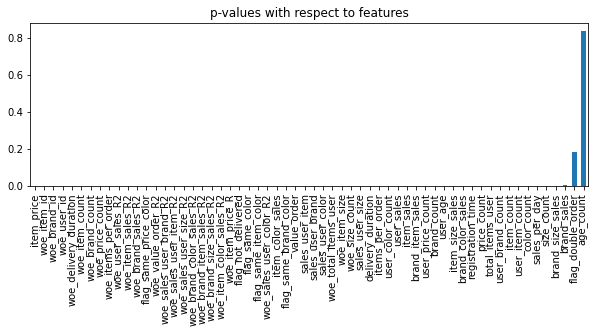

In [47]:
f_test = f_classif(df_known.drop('return', axis=1).copy(), df_known['return']) # F-test for binary target classification
p_values = pd.Series(f_test[1], index = df_known.drop('return', axis=1).copy().columns)  # Get p-values
p_values.sort_values(ascending = True, inplace = True)  # Sort p-values
plt.figure(figsize=(10,3))
p_values.plot.bar()
plt.title('p-values with respect to features')

In [48]:
L_selec = p_values[p_values>0.05].index # Features with p-value higher than 0.05
df_known = df_known.drop(L_selec, axis = 1).copy() # Remove from known dataset
df_unknown = df_unknown.drop(L_selec, axis = 1).copy() # Remove from unknown dataset

For $\alpha=0.05$ the F-test suggests to remove `age_count` and `flag_double_order`. Those already had the lowest Fisher Score. Following this, the cleaned datasets consist of 58 features that can be used for predictiv model building.

## 4. Model tuning and selection  <a class='anchor' id='fourth-bullet'></a>

The goal of this section is to build a [Stacking Classifier](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/) (heterogenous ensemble) consisting of a XGBoost Classifier and a Random Forest Classifier. Those are advantagous over parametric models since they have a variety of possibilities to be tuned and are the most [promising candidates](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/). The underlying simple learners are classification trees in both cases. At the same time they are based on different ensemble learning principles, namly boosting and randomized bagging (homogeneous ensembles). Thus enough diversity is provided for information gains by stacking.

In [49]:
!pip install xgboost
import xgboost as xgb # Underlying prediction model
from sklearn.ensemble import RandomForestClassifier # Underlying prediction model
from sklearn.ensemble import StackingClassifier # Final prediction model
from sklearn.linear_model import LogisticRegression # Meta-learner
from sklearn.model_selection import train_test_split # Split in test and train for CV
from sklearn.model_selection import GridSearchCV # Parameter tuning
from sklearn import metrics # Parameter tuning
from matplotlib import pyplot # Plots

For the tuning on the known data let's change all numeric variables with digits to `float32` and the remaining data (flags, counts) to `int16` in order to reduce memory consumption.

In [50]:
num_vars = df_known.select_dtypes(include=(np.float64)).columns
df_known[num_vars] = df_known[num_vars].astype(np.float32)
num_vars = df_known.select_dtypes(include=(np.int32,np.int64)).columns
df_known[num_vars] = df_known[num_vars].astype(np.int16)

Heuristically a random 70% train set and 30% test set split partitions the known data and separates the target `return`. Tuning is conducted on the train set whereas the test set is used to check for model behavior on unseen data and testing of the final model. 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_known.drop('return', axis=1).copy(), df_known['return'], 
                                                    test_size=0.3, random_state=1234)

To get a first impression of how the XGBoost model and the Random Forest model adapt to the train set, the respective [relative feature importencies](https://machinelearningmastery.com/calculate-feature-importance-with-python/) are plotted for the default models.

In [52]:
def plot_feature_importance(model,features,name):
    model.fit(X_train, y_train) # Fit model to train data
    importances = model.feature_importances_ # Get feature importencies
    indices = np.argsort(importances) # Sort features by importencies
    # Plot feature importencies depending on model
    plt.figure(figsize=(10,10))
    plt.title('Feature Importances ' + name)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center') # Generate bars
    plt.yticks(range(len(indices)), [features[i] for i in indices]) # Label bars on y-axis
    plt.xlabel('Relative Importance') # Label x-axis
    plt.show()

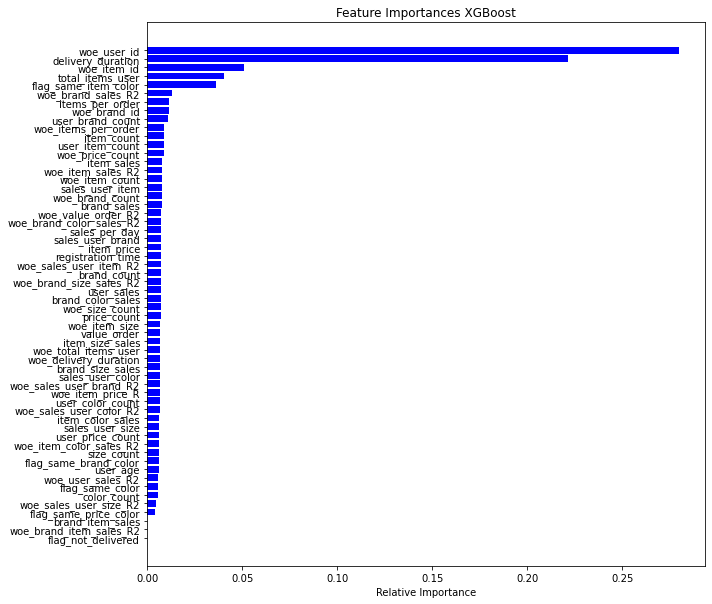

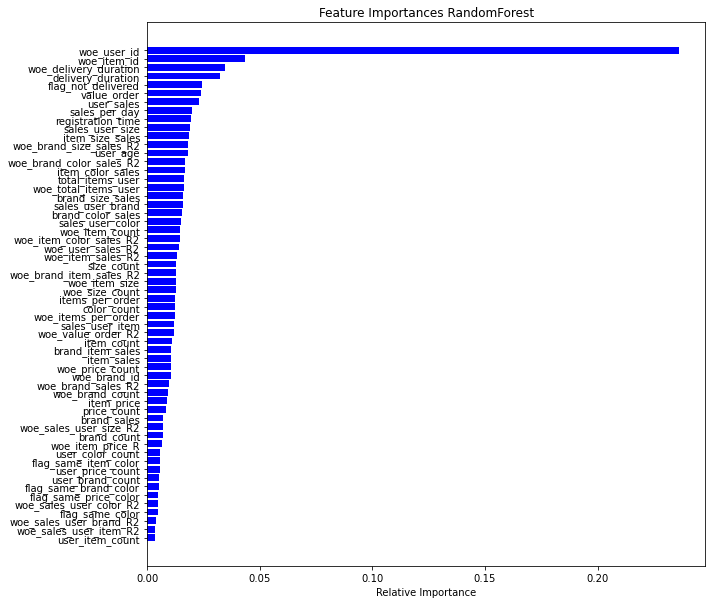

In [53]:
plot_feature_importance(xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False), 
                        df_known.columns, 'XGBoost')
plot_feature_importance(RandomForestClassifier(), df_known.columns, 'RandomForest')

At least 2 of the 5 most importent features in both models originally had problems with missing values in the unknown dataset. Especially `woe_user_id` had over 30,000 missing values. Attaching great importency to those features during model training results in overfitting since the importency in the unknown dataset is lower. However, when removed a substancial amount of relevant information will get lost. Therefore the feature importency in the XGBoost model and Random Forest model has to be controlled for in the following steps.

### XGBoost

Let's start with [tuning the XGBoost model](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e). The default model is fitted to the train set with increasing `n_estimators`. Predictions are made both for train as well as test set and `early_stopping_rounds` is applied regarding the `AUC` of test predictions. This gives a first impression of the model behaviour towards unseen data.

[0]	validation_0-auc:0.88027	validation_1-auc:0.87743
[1]	validation_0-auc:0.88265	validation_1-auc:0.87977
[2]	validation_0-auc:0.88400	validation_1-auc:0.88133
[3]	validation_0-auc:0.88517	validation_1-auc:0.88204
[4]	validation_0-auc:0.88553	validation_1-auc:0.88247
[5]	validation_0-auc:0.88594	validation_1-auc:0.88284
[6]	validation_0-auc:0.88650	validation_1-auc:0.88307
[7]	validation_0-auc:0.88716	validation_1-auc:0.88349
[8]	validation_0-auc:0.88745	validation_1-auc:0.88364
[9]	validation_0-auc:0.88800	validation_1-auc:0.88408
[10]	validation_0-auc:0.88840	validation_1-auc:0.88444
[11]	validation_0-auc:0.88887	validation_1-auc:0.88454
[12]	validation_0-auc:0.88957	validation_1-auc:0.88487
[13]	validation_0-auc:0.89007	validation_1-auc:0.88493
[14]	validation_0-auc:0.89061	validation_1-auc:0.88513
[15]	validation_0-auc:0.89133	validation_1-auc:0.88541
[16]	validation_0-auc:0.89199	validation_1-auc:0.88559
[17]	validation_0-auc:0.89232	validation_1-auc:0.88575
[18]	validation_0-au

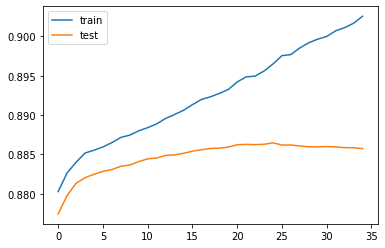

In [54]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False) # Define model
evalset = [(X_train, y_train), (X_test,y_test)] # Define evaluation sets
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc',
          eval_set=evalset, verbose = True) # Fit model to known data
results = model.evals_result() # Get evaluation results
# Plot learning curves from evaluation results
pyplot.plot(results['validation_0']['auc'], label='train')
pyplot.plot(results['validation_1']['auc'], label='test')
pyplot.legend()
pyplot.show()

The leaning curves show that model training with `n_estimators` higher than 24 does result in a falling `AUC` score for the test set. This suggests to look for a short XGBoost model since those generalize better to unseen data. The model complexity parameters of interest are `n_estimators`, `max_depth` and `learning_rate`. Those have an inverse relationship to eachother. Hence against the runtime problems due to dimensionality it is reasonable to tune them at the same time in one grid. The default XGBoost model suggested `n_estimators` = 24 for the default parameters `max_depth` = 6 and `learning_rate` = 0.3. Hence `n_estimators` between 20 and 50 with steps of five, `max_depth` til 4 and `learning_rate` values around 0.3 build the parameter grid. Cross-validation is used to identify the optimal parameter combination. The folds are set to 5 in order to reduce the runtime. 

In [55]:
# NOTE: n_jobs = -1 !  All physical cores are used and available resources will be consumed.
xgb_param_grid ={
                'n_estimators': np.arange(20,50,5), # Values between 20 and 50 in 5 unit steps
                'max_depth': [4,5,6],  
                'learning_rate': np.arange(0.27,0.34,0.01), # Values between 0.26 and 0.34 in 0.01 unit steps
                }
# Define GridSearch (XGBClassifier with 5 fold cross-validation and AUC as evaluation score)
gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', missing=None, eval_metric='auc',
                      use_label_encoder=False), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1) 
gs_xgb.fit(X_train, y_train) # Fit GridSearch 
print('Best CV AUC: %0.4f' % gs_xgb.best_score_) # Get best CV score
print('Optimal XGB meta-parameters:')
print(gs_xgb.best_params_) # Get best parameters

Best CV AUC: 0.8871
Optimal XGB meta-parameters:
{'learning_rate': 0.28, 'max_depth': 5, 'n_estimators': 35}


Let's refine the value of `n_estimators` by cross-validation of a sequence of single steps from 30 to 40.

In [56]:
# NOTE: n_jobs = -1 !  All physical cores are used and available resources will be consumed.
xgb_param_grid ={
                'n_estimators': np.arange(30,41,1), # Values from 30 to 40 in 1 unit steps
                'max_depth': [5],   
                'learning_rate': [0.28]
                }  
# Redefine GridSearch with new parametergrid (XGBClassifier with 5 fold cross-validation and AUC as evaluation score)
gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', missing=None, eval_metric='auc',
                      use_label_encoder=False), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1) 
gs_xgb.fit(X_train, y_train) # Fit GridSearch 
print('Best CV AUC: %0.4f' % gs_xgb.best_score_) # Get best CV score
print('Optimal XGB meta-parameters:')
print(gs_xgb.best_params_) # Get best parameters

Best CV AUC: 0.8871
Optimal XGB meta-parameters:
{'learning_rate': 0.28, 'max_depth': 5, 'n_estimators': 32}


To prevent XGBoost from overfitting the features importencies have to be adjusted. This is done by highly [randomizing the feature draws](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e) via `colsample_bytree`. A subset of features is selected for each base learner i.e. tree with `max_depth` = 5. Since the whole known dataset does not entail information about the feature importency problem, tuning `colsample_bytree` there might be missleading. Hence the respective learning curves are generated to find a reasonable and conservative value for this parameter.

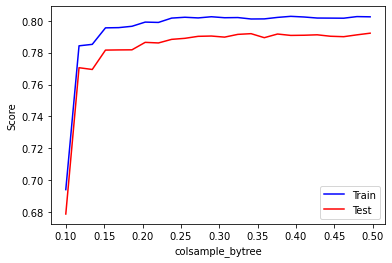

In [57]:
colsample = list(np.arange(0.1,0.5,1/58)) # List of percentage values that correspond to a 1 unit increase in colsample
train_results = []
test_results = []
for sample in colsample:
    # Define model at level of colsample 
    model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc', 
                              n_estimators=32, max_depth=5, learning_rate=0.28, colsample_bytree=sample)
    model.fit(X_train, y_train) # Fit model
    train_pred = model.predict(X_train) 
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc) # Append value for AUC on train set to train_results
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc) # Append value for AUC on train set to test_results
# Plot AUC values for train and test set
line1, = plt.plot(colsample, train_results, 'b', label='Train')
line2, = plt.plot(colsample, test_results, 'r', label='Test')
plt.ylabel('Score')
plt.xlabel('colsample_bytree')
plt.legend();

The score returns to an increase in `colsample_bytree` are dimishing quickly. To find a conservative value the elbow method is used in this inverse representation. Therefore a value of `colsample_bytree` = 0.15 is reasonable. Having 58 features in total this translates into a pool of 8 randomly selected features per base learner.

Since the feature importency problem is considered the main source of overfitting further parameter addressing this like `subsample` or the regularization parameter `gamma`, `lambda` or `alpha` are neglect. Hence setting `colsample_bytree` finishes the XGBoost tuning.

### RandomForest
Now let's [turn to Random Forest](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d).   Again the feature importency problem has to be dealt with. This is done by initially reducing `max_features` to the smallest value possible, namely 1 vgl. Probst, Wright & Boulesteix (2019, S.6). This extremely randomized model selects at each node of a base learner one random feature for splitting. As a side effect this speeds the model up considerably.

Further speed is gained by tuning `max_samples` i.e. the bootstrap sample size drawn for each base estimator. To get an idea of this the learning curves of the default model are plotted.

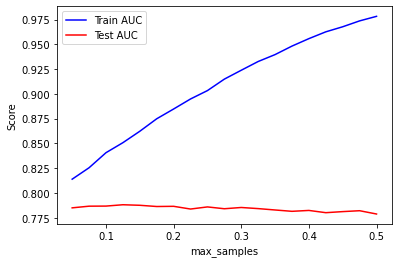

In [58]:
# NOTE: n_jobs = -1 !  All physical cores are used and available resources will be consumed.
max_samples = list(np.arange(0.05, 0.525, 0.025)) # List of heuristic percentages for max samples 
train_results = []
test_results = []
for estimator in max_samples:
    rf = RandomForestClassifier(max_samples=estimator, random_state=1234, n_jobs=-1) # Define model at level of max samples 
    rf.fit(X_train, y_train) # Fit model
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc) # Append value for AUC on train set to train_results
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc) # Append value for AUC on train set to test_results
# Plot AUC values for train and test set
line1, = plt.plot(max_samples, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_samples, test_results, 'r', label='Test AUC')
plt.ylabel('Score')
plt.xlabel('max_samples')
plt.legend();

`max_samples` can be set to small values, it eventually even increases predictiv power. To initalize tuning let's set `max_features` = 1 and tune the splitting `criterion` and `max_samples` first. The cross-validation again consists of 5 folds with the `AUC` as score of interest.

In [59]:
# NOTE: n_jobs = -1 !  All physical cores are used and available resources will be consumed.
rf_param_grid = { 
                'criterion': ['entropy','gini'],  
                'max_samples': np.arange(0.1, 0.26, 0.01), # Values from 0.1 to 0.25 in 0.01 unit steps
                'max_features': [1], 
                'random_state': [1234]
                }
# Define GridSearch (RFClassifier with 5 fold cross-validation and AUC as evaluation score)
gs_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, scoring='roc_auc', cv=5, 
                     verbose=0, n_jobs=-1)
gs_rf.fit(X_train, y_train) # Fit GridSearch
print('Best CV AUC: %0.4f' % gs_rf.best_score_) # Get best CV score
print('Optimal RF meta-parameters:')
print(gs_rf.best_params_) # Get best parameters

Best CV AUC: 0.8228
Optimal RF meta-parameters:
{'criterion': 'entropy', 'max_features': 1, 'max_samples': 0.20999999999999996, 'random_state': 1234}


The high randomization causes a relatively low cross-validation `AUC`. However, this is due to the fact that `max_features` = 1 addresses a problem that is opaque to the model during training and testing. Further let's explore the `max_depth` by again taking advantage of the learning curves. This will reveal a range of values for `max_depth` that will be used for tuning.

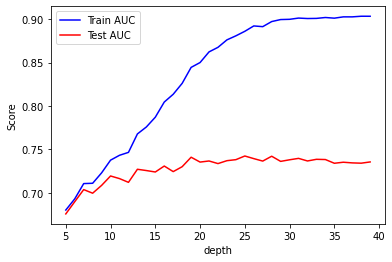

In [60]:
# NOTE: n_jobs is set to -1!  All physical cores are used and available resources will be consumed.
depth = list(np.arange(5, 40, 1)) # List of max_depth values
train_results = []
test_results = []
for estimator in depth:
    rf = RandomForestClassifier(max_depth=estimator, random_state=1234, max_features=1, max_samples=0.21,
                                criterion='entropy', n_jobs=-1) # Define model at max_depth level 
    rf.fit(X_train, y_train) # Fit model
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc) # Append value for AUC on train set to train_results
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc) # Append value for AUC on train set to test_results
# Plot AUC values for train and test set
line1, = plt.plot(depth, train_results, 'b', label='Train AUC')
line2, = plt.plot(depth, test_results, 'r', label='Test AUC')
plt.ylabel('Score')
plt.xlabel('depth')
plt.legend();

Apparently the leaning curve for `max_depth` reaches the highest value in the range from 24 to 30 on the test set.

In [61]:
# NOTE: n_jobs = -1 !  All physical cores are used and available resources will be consumed.
rf_param_grid = { 
                'max_depth': list(np.arange(24, 30, 1)), # Values from 24 to 29 in 1 unit steps   
                'criterion': ['entropy'], 
                'max_samples': [0.21],
                'max_features': [1],
                'random_state': [1234]
                } 
# Redefine GridSearch with new parametergrid (RFClassifier with 5 fold cross-validation and AUC as evaluation score)
gs_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, scoring='roc_auc', cv=5,
                     verbose=0, n_jobs=-1)
gs_rf.fit(X_train, y_train) # Fit GridSearch (RFClassifier with 5 fold cross-validation and AUC as evaluation score)
print('Best CV AUC: %0.4f' % gs_rf.best_score_) # Get best CV score
print('Optimal RF meta-parameters:')
print(gs_rf.best_params_) # Get best paramters

Best CV AUC: 0.8229
Optimal RF meta-parameters:
{'criterion': 'entropy', 'max_depth': 26, 'max_features': 1, 'max_samples': 0.21, 'random_state': 1234}


Finally, the `n_estimators` of the Random Forest model does not require to be tuned. Theoretically speaking any additional tree is beneficial even though the score gains to this are dimishing. Hence `n_estimators` is set to the maximum affortable level of 1500. This finishes the Random Forest tuning.

### Stacking Ensemble
The two tuned ensemble lerners XGBoost and Random Forest are now combined into one heterogenous ensemble using stacking. The predictions of both models are incorporated as features in a meta leaner, namely a logistic regression that yields the final predictions.

In [62]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc',
                            n_estimators=32, max_depth=5, learning_rate=0.28, colsample_bytree=0.15) # Final XGBoost model
rf_clf = RandomForestClassifier(n_estimators=1500, max_depth=26, criterion='entropy', max_features=1,
                                max_samples=0.21, random_state=1234) # Final Random Forest model
estimators = [  ('xgb', xgb_clf), ('rf', rf_clf)  ] # List of models with specifications
# NOTE: n_jobs is set to -1!  All physical cores are used and available resources will be consumed.
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1) # Stacking models 

## 5. Model evaluation and cost-sensitive classification  <a class='anchor' id='fifth-bullet'></a>
To assess the predictive performance of the stacking ensemble the test set is used. This is done with the `AUC` and the Brier score as accuracy measures. Afterwards the intend is on making the stacking classifier cost-sensitiv to minimize the cost the shop has to face. This is done by using the provided cost-matrix of the assignment. 

In order to see if the heterogenous ensemble impoves over its base learners XGBoost and Random Forest a comparison is conducted. We check model accuracy on the test set by calculating and visualizing the `AUC`.

Model trained: StackingClassifier
The AUC on the test set of this model is: 0.8734

Model trained: XGBoost
The AUC on the test set of this model is: 0.8699

Model trained: RandomForest
The AUC on the test set of this model is: 0.8295



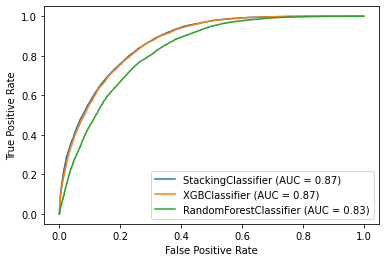

In [63]:
fig, ax = plt.subplots() # Create plot
# Create lists of models for the loop
models = [stack_clf, xgb_clf, rf_clf] 
names = ['StackingClassifier', 'XGBoost', 'RandomForest']
# Loop to train and evaluate a model
for i in range(0,len(names)): 
    print('Model trained: {}'.format(names[i]))
    # Fit model using the training set
    models[i].fit(X_train, y_train) 
    # Make prediction using the test set
    Int = models[i].predict_proba(X_test)[:,1] 
    # Calcuate AUC score by using the prediction and y_test
    print('The AUC on the test set of this model is: {:.4f}'.format(metrics.roc_auc_score(y_test, Int)))     
    print('') # use our predictions on the test set and compare them to their actuals, y_test
    metrics.plot_roc_curve(models[i], X_test, y_test, ax=ax) # Plot ROC curve

The `AUC` scores and plots show that the stacking ensemble improves slightly over the XGBoost model. The reasons for the relative low `AUC` value of Random Forest is again the high level of randomization.

In [64]:
prob = stack_clf.predict_proba(X_test)[:, 1] # Probability prediction of stacking model
bs_StackingClassifier = np.sum( (y_test - prob) **2) / len(y_test) # Brier score of the StackingClassifier
bs_XGBoost = np.sum( (y_test - xgb_clf.predict_proba(X_test)[:,1]) **2) / len(y_test) # Brier score of XGBoost
bs_RandomForest = np.sum( (y_test - rf_clf.predict_proba(X_test)[:,1]) **2) / len(y_test) # Brier score of the RandomForest

In [65]:
print('Brier score of the StackingClassifier: {:.4}'.format(bs_StackingClassifier))
print('Brier score of XGBoost: {:.4}'.format(bs_XGBoost))
print('Brier score of the RandomForest: {:.4}'.format(bs_RandomForest))

Brier score of the StackingClassifier: 0.1452
Brier score of XGBoost: 0.1501
Brier score of the RandomForest: 0.1765


The Brier score (Mean Squared Error of probability forecasts) shows a similar pattern as the `AUC`. Here the stacking ensemble yields a lower score than XGBoost and Random Forest which correspondes to higher accuracy. We can conclude that the stacking ensemble improves the predictive performance.

Now let's transform the prediction to cost-sensitive classifications for the target `return` i.e. such that the cost caused from false positive and false negative classification is minimized. Hence the provided cost-matrix and the corresponding theoretical representation are printed.

In [66]:
cost_matrix = pd.DataFrame({'actual_Neg(0)': [0, '0.5*v'],
                            'actual_Pos(1)': ['0.5*5*(3+0.1*v)', 0]}, 
                            index= ['predicted_Neg(0)', 'predicted_Pos(1)'])
print('cost-matrix as defined for the assignment:')
print(' ')
print(cost_matrix)

cost-matrix as defined for the assignment:
 
                 actual_Neg(0)    actual_Pos(1)
predicted_Neg(0)             0  0.5*5*(3+0.1*v)
predicted_Pos(1)         0.5*v                0


In [67]:
cost_matrix_theory = pd.DataFrame({'actual_Good(0)': ['C(g,G)', 'C(b,G)'],
                                   'actual_Bad(1)': ['C(g,B)', 'C(b,B)']}, 
                                   index= ['predicted_Good(0)', 'predicted_Bad(1)'])
print('Theoretical cost-matrix with Neg=Good and Pos=Bad:')
print(' ')
print(cost_matrix_theory)

Theoretical cost-matrix with Neg=Good and Pos=Bad:
 
                  actual_Good(0) actual_Bad(1)
predicted_Good(0)         C(g,G)        C(g,B)
predicted_Bad(1)          C(b,G)        C(b,B)


The bad class is defined by `return` = 1 i.e. $y=1$. Hence the negative class corresponds to the good class and the positiv class corresponds to the bad class. Costs are only assignt to missclassification between prediction and actual realization. Those are the false positives (FP) with $C(b,G)=0.5\times v$ and false negatives (FN) with $C(g,B)=0.5\times5\times(3+0.1\times v)$ where the small letter is the prediction and the capital letter the realization. The costs are unequally burdening hence a cost-minimal threshold other than $0.5$ for the default classification exists. Since overfitting is potentially a problem an analytical solution to this is favored over some empirical determination on the training and test set. Hence the approach for the cost-minimal thresholds follows Elkan, C. (2001). Since the costs depend on the `item_price`, cost-minimal thesholds should be determined accordingly. It follows

$$ 𝑝(𝑏|X) ≥ \tau^∗_i = \frac{𝐶(𝑏,𝐺)_i}{ 𝐶(𝑏,𝐺)_i + 𝐶(𝑔,𝐵)_i} = \frac{0.5\times v_i}{ 0.5\times v_i + 0.5\times5\times(3+0.1 \times v_i)} $$

Let's consider calculations both at the mean and for the individual values of `item_price`.

In [68]:
threshold_mean = ((0.5*np.mean(X_test['item_price'])) / # Threshold for mean value of item_price
                   ((0.5*5*(3+0.1*np.mean(X_test['item_price']))) + (0.5*np.mean(X_test['item_price']))))
thresholds_indiv = ((0.5*X_test['item_price']) / # Thresholds for individual values of item_price
                    ((0.5*5*(3+0.1*X_test['item_price'])) + (0.5*X_test['item_price'])))

In [69]:
print('The cut-offs at the mean price is: {}'.format(threshold_mean))
print(' ')
print('The price individual cut-offs are:')
print(thresholds_indiv)

The cut-offs at the mean price is: 0.5780723890788789
 
The price individual cut-offs are:
13504    0.533066
72599    0.622193
42217    0.443701
97650    0.499582
99120    0.641971
           ...   
51876    0.583229
29046    0.571292
75568    0.571292
99025    0.533066
1512     0.533066
Name: item_price, Length: 30000, dtype: float64


At the mean value of `item_price` the burden from $C(b,G)$ is higher than from $C(g,B)$. Hence the cut-off is larger than 0.5. 

Now we compare the classification for the default cut-off $0.5$, the cost-minimal cut-off for the mean of `item_price` and the `item_price` individual cost-minimal cut-offs. Therefore the cut-offs are used to dichotomize the stacking ensemble predictions to yield classifications.

In [70]:
y_prob = pd.Series(prob, index=y_test.index, name='return_prob')
cost_data = pd.merge(X_test['item_price'], y_test, how='left', left_index=True, right_index=True)
cost_data['default'] = np.where(y_prob >= .5, 1, 0) # Classification at the default cut-off 0.5
cost_data['mean_price'] = np.where(y_prob >= threshold_mean, 1, 0) # Classification at the mean price cut-off
cost_data['indiv'] = np.where(y_prob >= thresholds_indiv, 1, 0) # Classification at the individual price cut-off

In [71]:
print('E[default]: {}'.format(np.mean(cost_data['default'])), # Expected value of default return classification 
      'E[mean_price]: {}'.format(np.mean(cost_data['mean_price'])), # Expected value of mean_price return classification
      'E[indiv]: {}'.format(np.mean(cost_data['indiv']))) # Expected value of individual return classification 
cost_data

E[default]: 0.46453333333333335 E[mean_price]: 0.41623333333333334 E[indiv]: 0.4384


,item_price,return,default,mean_price,indiv
13504,39.900002,0,0,0,0
72599,139.899994,0,0,0,0
42217,19.900000,0,1,1,1
97650,29.900000,0,1,1,1
99120,259.950012,1,0,0,0
...,...,...,...,...,...
51876,69.900002,0,0,0,0
29046,59.900002,0,1,1,1
75568,59.900002,0,0,0,0
99025,39.900002,0,0,0,0


The number of classifications `return` = 1 decreases compared to the default cut-off. This goes along with the earlier finding that the burden from $C(b,G)$ is higher. However, the individual cut-offs classifications seemingly balances better between both cost errors by incorporating the price levels. To check this the confusion matrix entries of interest are identified, namely the number of FPs and FNs.

The theoretical confusion matrix with Pos=Bad:
                 actual_Neg(0) actual_Pos(1)
predicted_Neg(0)            TP            FN
predicted_Pos(1)            FP            TN
 
Confusion matrix for the default cut-off (transposed by labels):


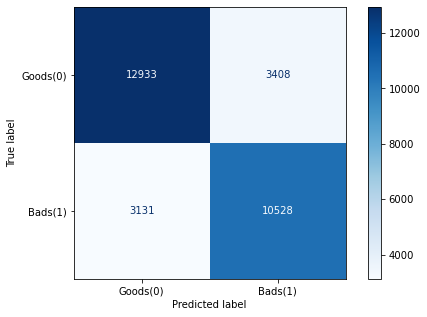

For the default cut-off FP is 3408 and FN is 3131
For the mean_price cut-off FP is 2754 and FN is 3926
For the individual cut-offs FP is 3062 and FN is 3569


In [72]:
confusion_matrix = pd.DataFrame({'actual_Neg(0)': ['TP', 'FP'],
                            'actual_Pos(1)': ['FN', 'TN']}, index= ['predicted_Neg(0)', 'predicted_Pos(1)'])
print('The theoretical confusion matrix with Pos=Bad:')
print(confusion_matrix)
print(' ')
print('Confusion matrix for the default cut-off (transposed by labels):')
plt.rcParams['figure.figsize'] = (8,5)
metrics.plot_confusion_matrix(stack_clf, X_test, y_test, labels=[0, 1], display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()
print('For the default cut-off FP is %0.f and FN is {}'.format((np.where(((cost_data['return'] == 1) & (cost_data['default'] == 0)), 1, 0)).sum()) 
      % np.where(((cost_data['return'] == 0) & (cost_data['default'] == 1)), 1, 0).sum()) # Identify FP and FN for default threshold classification
print('For the mean_price cut-off FP is %0.f and FN is {}'.format((np.where(((cost_data['return'] == 1) & (cost_data['mean_price'] == 0)), 1, 0)).sum()) 
      % np.where(((cost_data['return'] == 0) & (cost_data['mean_price'] == 1)), 1, 0).sum()) # Identify FP and FN for mean_price threshold classification
print('For the individual cut-offs FP is %0.f and FN is {}'.format((np.where(((cost_data['return'] == 1) & (cost_data['indiv'] == 0)), 1, 0)).sum()) 
      % np.where(((cost_data['return'] == 0) & (cost_data['indiv'] == 1)), 1, 0).sum()) # Identify FP and FN for individual thresholds classification

The numbers of FP and FN according to the cut-offs confirm that the individual cut-offs balance FP and FN compared to the more extreme results from the default and the mean_price cut-offs that seem to classify more in favor of one of the errors. Let's check whether this goes along with lower costs.

In [73]:
def error_cost(cutoff_typ):
    FN_cost = np.where(((cost_data['return'] == 1) & (cost_data[cutoff_typ] == 0)), 
                       ((0.5 * 5 * (3 + 0.1 * cost_data['item_price']))), 0) # FN costs depending on cut-off
    FP_cost = np.where(((cost_data['return'] == 0) & (cost_data[cutoff_typ] == 1)), 
                       ((0.5 * cost_data['item_price'])), 0) # FP costs depending on cut-off
    return((FP_cost.sum() + FN_cost.sum())/len(y_test)) # Total error cost

In [74]:
print('The error cost for the default cut-off is: {}'.format(error_cost('default')))
print('The error cost for the mean_price cut-off is: {}'.format(error_cost('mean_price')))
print('The error cost for the individual cut-offs is: {}'.format(error_cost('indiv')))

The error cost for the default cut-off is: 6.416481437160572
The error cost for the mean_price cut-off is: 6.279120018802087
The error cost for the individual cut-offs is: 6.187210186972221


The error cost shows that the individual cut-offs minimize costs regarding both FP and FN error. Hence this analytical approach is used for classification.

### Prediction and classification  
Finally, the stacking ensemble is fitted to the whole known dataset and the target `return` of the unknown dataset is predicted. The cost-sensitiv classification is done by dichotomising the `return` probabilities $\hat{p}(y_i = 1|X_i)$ with the individual cut-offs $\tau^∗_i$ to $\hat{y}_i$  such that $\hat{y}_i \in  \{0,1\} \forall i$ with $\hat{y}_i=1$ if $\hat{p}(y_i = 1|X_i) > \tau^∗_i$ and $\hat{y}_i=0$ else.

Let's initially  change the data types in the unknown dataset according to the known dataset to reduce memory consumption.

In [75]:
num_vars = df_unknown.select_dtypes(include=(np.float64)).columns
df_unknown[num_vars] = df_unknown[num_vars].astype(np.float32)
num_vars = df_unknown.select_dtypes(include=(np.int32,np.int64)).columns
df_unknown[num_vars] = df_unknown[num_vars].astype(np.int16)

The stacking ensemble is fitted to the known data and with the features of the unknown dataset probabilistic predictions are made for the target `return`. 

In [76]:
stack_clf.fit(df_known.drop(['return'], axis=1).copy(), df_known['return']) # Fit stacking ensemble to the known dataset
pred_unknown = stack_clf.predict_proba(df_unknown)[:, 1] # Predict target probabilistically with unknown data

The predictions get formatted. As we know with certainty and originally from the exploratory data analysis that items with the flag `not_delivered` = 1 take on the target value `return` = 0, the respective predictions are adjusted accordingly.

In [77]:
y_prob = pd.Series(pred_unknown, index=list(range(100001, 150001)), name='return') # Formatting and naming predictions 
y_prob.index.names = ['order_item_id'] # Rename index

not_delivered = df_unknown['flag_not_delivered'] # Get not_delivered column
not_delivered.index = range(100001, 150001) # Set index equal to predictions
y_prob.loc[not_delivered.loc[not_delivered == 1].index] = 0 # Adjust predictions by not_delivered

Now the individual cost-minimal thresholds are calculated with the respective `item_price` values from the unknown dataset. Applying them to dichotomize the predictions yields the cost-sensitive classification.

In [78]:
thresholds_indiv = ((0.5*df_unknown['item_price']) / 
                    ((0.5*5*(3+0.1*df_unknown['item_price'])) + (0.5*df_unknown['item_price']))) # Calculate individual thresholds 
thresholds_indiv.index = range(100001, 150001) # Set index equal to predictions
y_classif = pd.Series(np.where(y_prob >= thresholds_indiv, 1, 0), index=list(range(100001, 150001)), name='return') # Apply thresholds
y_classif.index.names = ['order_item_id'] # Rename index
y_classif  # Check format

order_item_id
100001    1
100002    1
100003    1
100004    0
100005    0
         ..
149996    1
149997    0
149998    1
149999    0
150000    0
Name: return, Length: 50000, dtype: int32

Checking shape and format yields that all requirements are met. The classifications are exported as `.csv` to the directory this notebook is saved in.

In [79]:
# Writes .csv file with classifications to the directory of this file
y_classif.to_csv(os.path.join(os.path.dirname(os.path.realpath('608227.ipynb')),'608227.csv'))

# Or directory can be set manually by using predictions.to_csv('.../608227.csv') 

## 6. Conclusion <a class='anchor' id='sixth-bullet'></a>
The aim of this assignment was to predict and cost-sensitivly classify future customer returns of a clothing e-commerce shop based on provided datasets. Initially a **Exporatory data analysis** was conducted to get insights of peculiarities. This proved to be very helpfull and provided guidiance in decision-making throughout the whole modeling approach. The **Data preperation** part showed especially that domain knowledge is key in order to generate meaningful features, imputations in the unknown dataset where conducted by FCS and the feature selection was kept on a general level. Dealing with the data peculiarities via high randomization of the feature / column draws for learning **Model tuning and selection** was done by building an heterogenous stacking ensemble with XGBoost and Random Forest. **Model evaluation and cost-sensitv classification** showed that the stacking ensemble is indeed superior to the single homogenous ensembles. Further the dependency of the cost-matrix on the item price required a row-wise calculation of the cost optimal threshold in order to minimize the total classification cost. 

To further improve the performance additional and more heterogenous models could be included into the stacking ensemble. The imputation model for the unknown data could be selected and tuned on a train-test split of the known data. More features could be generated with other subgroups. Following this, the feature selection could be extended by more sophisticated methods or dimension reduction could be used to make the model more sparse. Moreover the binning for the WoE features can be refined by applying K-means or identifying the splits of tree models.

The possibilities to solve this assignment are comprehensive and diverse therefore the amount of what is learned during that is enormous.

## 7. Literature <a class='anchor' id='seventh-bullet'></a>
- Buuren, S. V., & Groothuis-Oudshoorn, K. (2010). mice: Multivariate imputation by chained equations in R. Journal of statistical software, 1-68.

- Elkan, C. (2001, August). The foundations of cost-sensitive learning. In International joint conference on artificial intelligence (Vol. 17, No. 1, pp. 973-978). Lawrence Erlbaum Associates Ltd.

- Probst, P., Wright, M. N., & Boulesteix, A. L. (2019). Hyperparameters and tuning strategies for random forest. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 9(3), e1301.

- Van Buuren, S. (2018). Flexible imputation of missing data. CRC press.